In [1]:
import matplotlib.pyplot as plt
from rvseg import dataset

%matplotlib inline

Using TensorFlow backend.


## Visualize effects of data augmentation

In [2]:
data_dir = "/home/paperspace/Developer/software/cardiac-segmentation/test-assets/"

augmentation_args = {
    'rotation_range': 180,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.05,
    'fill_mode' : 'nearest',
    'alpha': 500,
    'sigma': 20,
}

(train_generator, train_steps_in_epoch,
 val_generator, val_steps_in_epoch) = dataset.create_generators(
    data_dir=data_dir,
    batch_size=16,
    validation_split=0.0,
    mask='both',
    shuffle=True,
    seed=0,
    normalize_images=True,
    augment_training=False,
    augment_validation=False,
    augmentation_args=augmentation_args)

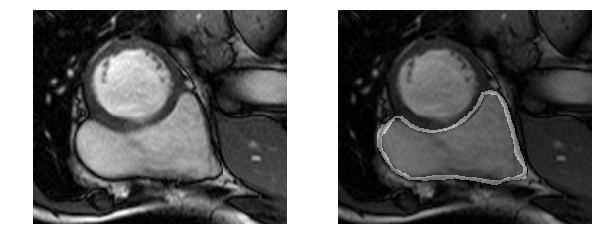

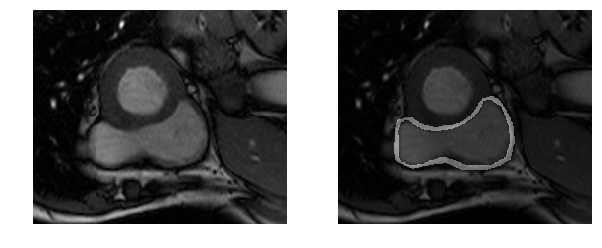

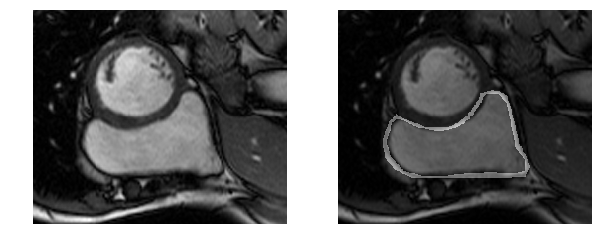

In [3]:
images, masks = next(train_generator)
for image,mask in zip(images, masks):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.imshow(mask[:,:,1], cmap=plt.cm.gray, alpha=0.4)

## Verify reproducibility of shuffling

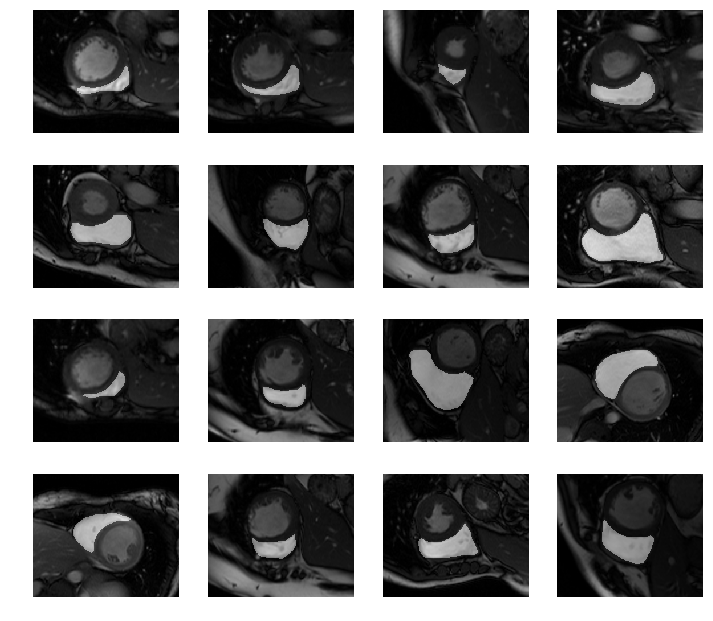

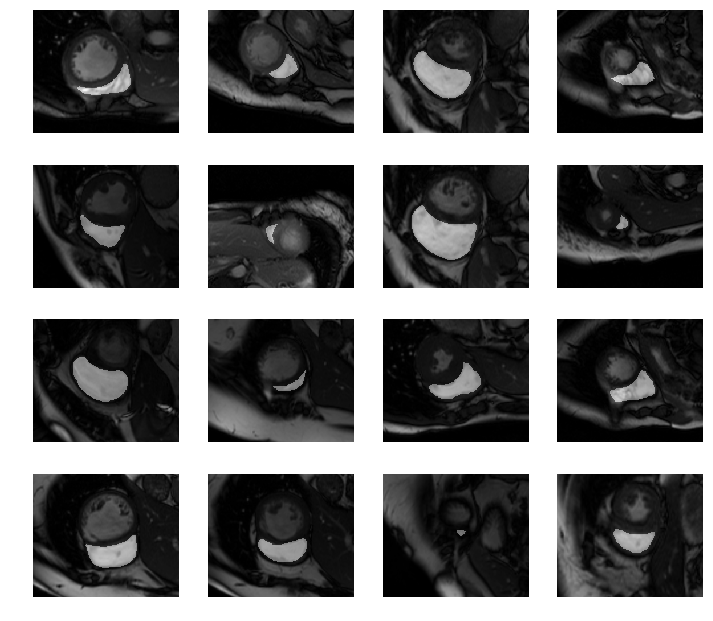

In [17]:
data_dir = "/home/paperspace/Developer/datasets/rvsc/TrainingSet/"

seed = 1

(train_generator, train_steps_in_epoch,
 val_generator, val_steps_in_epoch) = dataset.create_generators(
    data_dir=data_dir,
    batch_size=16,
    validation_split=0.2,
    mask='inner',
    shuffle_train_val=True,
    shuffle=True,
    seed=seed,
    normalize_images=True,
    augment_training=False,
    augment_validation=False)

def gridplot(images, masks, cols):
    rows = len(images)//cols + 1
    plt.figure(figsize=(12,2.75*rows))
    for i,(image,mask) in enumerate(zip(images, masks)):
        plt.subplot(rows, cols, i+1)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        plt.imshow(mask[:,:,1], cmap=plt.cm.gray, alpha=0.4)

images, masks = next(train_generator)
gridplot(images, masks, cols=4)    
    
images, masks = next(val_generator)
gridplot(images, masks, cols=4)